In [ ]:
# Import Libraries
import pandas as pd  # Untuk analisis data dan manipulasi DataFrame
import numpy as np  # Untuk operasi matematika
import matplotlib.pyplot as plt  # Untuk visualisasi data
import seaborn as sns  # Untuk visualisasi data
from sklearn.model_selection import train_test_split  # Untuk membagi dataset menjadi training dan testing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder  # Untuk normalisasi data dan encoding label
from sklearn.neighbors import KNeighborsClassifier  # Untuk klasifikasi menggunakan KNN
from sklearn.tree import DecisionTreeClassifier  # Untuk klasifikasi menggunakan Decision Tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix  # Untuk evaluasi model

# 1. Load Datasets
movies_data = pd.read_csv("movies_metadata.csv")
rating = pd.read_csv("ratings_small.csv")

# 2. Data Exploration
print(movies_data.info())
print(movies_data.head())
print(movies_data.sample(10))

# 3. Preprocessing 'release_date'
movies_data["release_date"] = pd.to_datetime(movies_data["release_date"], errors='coerce', format='%Y-%m-%d')
invalid_dates = movies_data[movies_data["release_date"].isna()]
print(f"Invalid dates: {invalid_dates}")

# 4. Preprocessing 'revenue' and 'budget'
# Convert 'revenue' and 'budget' to numeric and coerce errors to NaN
movies_data["revenue"] = pd.to_numeric(movies_data["revenue"], errors='coerce')
movies_data["budget"] = pd.to_numeric(movies_data["budget"], errors='coerce')

# 5. Handle Missing Values
# Fill missing 'revenue' and 'budget' with 0 (assuming movies with no budget/revenue are low-budget/failed)
movies_data["revenue"].fillna(0, inplace=True)
movies_data["budget"].fillna(0, inplace=True)

# 6. Calculate 'profit'
movies_data["profit"] = movies_data["revenue"] - movies_data["budget"]
invalid_rows = movies_data[movies_data["profit"].isna()]
print(f"Invalid profit rows: {invalid_rows}")

# 7. Handle Missing 'runtime'
# Fill missing 'runtime' with the median runtime
movies_data["runtime"].fillna(movies_data["runtime"].median(), inplace=True)

# 8. Handle Categorical Variables: Encoding 'original_language'
# We can use Label Encoding for categorical variables like 'original_language'
label_encoder = LabelEncoder()
movies_data["original_language"] = label_encoder.fit_transform(movies_data["original_language"].astype(str))

# 9. Feature Engineering
# Create a new feature: profit-to-budget ratio (avoid division by zero)
movies_data["profit_to_budget_ratio"] = np.where(movies_data["budget"] == 0, 0, movies_data["profit"] / movies_data["budget"])

# 10. Visualize Profit Distribution
plt.figure(figsize=(10, 6))
movies_data["profit"].hist(bins=100)
plt.title("Profit Movies Distribution")
plt.show()

# 11. Boxplot for 'profit' and 'runtime'
plt.figure(figsize=(10, 6))
sns.boxplot(data=movies_data, x="profit")
plt.title("Profit Boxplot")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=movies_data, x="runtime")
plt.title("Runtime Boxplot")
plt.show()

# 12. Scatterplot for 'runtime' vs 'profit'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movies_data, x="runtime", y="profit")
plt.title("Runtime vs Profit")
plt.show()

# 13. Filter profitable movies and visualize
profitable_movies = movies_data[movies_data["profit"] > 0]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=profitable_movies, x="runtime", y="profit")
plt.title("Profitable Movies: Runtime vs Profit")
plt.show()

# 14. Rating Median and Categorization
rating_movies = rating.groupby("movieId", as_index=False)["rating"].median()
rating_movies["good_movies"] = rating_movies["rating"] >= 3

# 15. Visualize Rating Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=rating_movies, x="rating")
plt.title("Rating Distribution")
plt.show()

# 16. Pie Chart for Good/Bad Movies
rating_movies["good_movies"].value_counts().plot(kind="pie", autopct='%1.1f%%')
plt.title("Good vs Bad Movies")
plt.show()

# 17. Merge Movie Data and Rating Data
movies_data["id"] = pd.to_numeric(movies_data["id"], errors='coerce')
new_df = movies_data.merge(rating_movies, left_on="id", right_on="movieId", how="inner")

# 18. Visualize Profit Distribution by Rating
plt.figure(figsize=(10, 6))
sns.histplot(data=new_df, x="profit", hue="good_movies", kde=True)
plt.title("Profit by Rating")
plt.show()

# 19. Scatterplot for 'rating' vs 'profit'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=new_df, x="rating", y="profit")
plt.title("Rating vs Profit")
plt.show()

# 20. Feature Selection for Machine Learning
def select_columns(df: pd.DataFrame, features: list, target: list = "rating"):
    df = df.dropna().reset_index(drop=True)
    X = df[features]
    y = (df[target] >= 3).astype("int")
    return X, y

# 21. Train-Test Split
features = ["budget", "popularity", "vote_average", "profit_to_budget_ratio", "runtime", "original_language"]
X, y = select_columns(new_df, features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 22. Feature Scaling
minmax = MinMaxScaler()
minmax.fit(X_train)

def scaling(df, scaler):
    scaled_array = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_array, columns=scaler.get_feature_names_out())
    return scaled_df

X_train_scaled = scaling(X_train, minmax)
X_test_scaled = scaling(X_test, minmax)

# 23. Train Models: KNN and Decision Tree
knn = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier()

# Train KNN and Decision Tree
knn.fit(X_train_scaled, y_train)
dt.fit(X_train_scaled, y_train)

# 24. Predictions
y_train_pred_knn = knn.predict(X_train_scaled)
y_train_pred_dt = dt.predict(X_train_scaled)
y_test_pred_knn = knn.predict(X_test_scaled)
y_test_pred_dt = dt.predict(X_test_scaled)

# 25. Evaluate Models using Cross-Tabulation
print("KNN Model Evaluation (Test Data):")
print(pd.crosstab(y_test, y_test_pred_knn))

print("Decision Tree Model Evaluation (Test Data):")
print(pd.crosstab(y_test, y_test_pred_dt))

# 26. Additional Metrics for Model Evaluation
# KNN Model
print("\nKNN Model Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_knn):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_knn):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_knn):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred_knn):.4f}")

# Decision Tree Model
print("\nDecision Tree Model Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_dt):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_dt):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_dt):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred_dt):.4f}")

# 27. Confusion Matrix Visualization
plt.figure(figsize=(10, 6))
cm_knn = confusion_matrix(y_test, y_test_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(10, 6))
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# Import Libraries
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import MinMaxScaler, LabelEncoder 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [33]:
# 1. Load Datasets
movies_data = pd.read_csv("movies_metadata.csv")
rating = pd.read_csv("ratings_small.csv")

C:\Users\andif\AppData\Local\Temp\ipykernel_22656\4143962083.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_data = pd.read_csv("movies_metadata.csv")


In [34]:
# 2. Data Exploration
print(movies_data.info())
print(movies_data.head())
print(movies_data.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [35]:
# 3. Preprocessing 'release_date'
movies_data["release_date"] = pd.to_datetime(movies_data["release_date"], errors='coerce', format='%Y-%m-%d')
invalid_dates = movies_data[movies_data["release_date"].isna()]
print(f"Invalid dates: {invalid_dates}")

Invalid dates:        adult belongs_to_collection budget  \
711    False                   NaN      0   
734    False                   NaN      0   
3460   False                   NaN      0   
3628   False                   NaN      0   
5879   False                   NaN      0   
...      ...                   ...    ...   
45148  False                   NaN      0   
45203  False                   NaN      0   
45338  False                   NaN      0   
45410  False                   NaN      0   
45461  False                   NaN      0   

                                                  genres  \
711                                                   []   
734                                                   []   
3460                       [{'id': 18, 'name': 'Drama'}]   
3628                                                  []   
5879   [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...   
...                                                  ...   
45148                   

In [36]:
# 4. Preprocessing 'revenue' and 'budget'
# Convert 'revenue' and 'budget' to numeric and coerce errors to NaN
movies_data["revenue"] = pd.to_numeric(movies_data["revenue"], errors='coerce')
movies_data["budget"] = pd.to_numeric(movies_data["budget"], errors='coerce')

In [ ]:
# 5. Handle Missing Values
# Fill missing 'revenue' and 'budget' with 0 (assuming movies with no budget/revenue are low-budget/failed)
movies_data["revenue"].fillna(0, inplace=True)
movies_data["budget"].fillna(0, inplace=True)

C:\Users\andif\AppData\Local\Temp\ipykernel_22656\7229797.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies_data["revenue"].fillna(0, inplace=True)
C:\Users\andif\AppData\Local\Temp\ipykernel_22656\7229797.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

In [38]:
# 6. Calculate 'profit'
movies_data["profit"] = movies_data["revenue"] - movies_data["budget"]
invalid_rows = movies_data[movies_data["profit"].isna()]
print(f"Invalid profit rows: {invalid_rows}")

Invalid profit rows: Empty DataFrame
Columns: [adult, belongs_to_collection, budget, genres, homepage, id, imdb_id, original_language, original_title, overview, popularity, poster_path, production_companies, production_countries, release_date, revenue, runtime, spoken_languages, status, tagline, title, video, vote_average, vote_count, profit]
Index: []

[0 rows x 25 columns]


In [39]:
# 7. Handle Missing 'runtime'
# Fill missing 'runtime' with the median runtime
movies_data["runtime"].fillna(movies_data["runtime"].median(), inplace=True)

C:\Users\andif\AppData\Local\Temp\ipykernel_22656\352376218.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies_data["runtime"].fillna(movies_data["runtime"].median(), inplace=True)


In [40]:
# 8. Handle Categorical Variables: Encoding 'original_language'
# We can use Label Encoding for categorical variables like 'original_language'
label_encoder = LabelEncoder()
movies_data["original_language"] = label_encoder.fit_transform(movies_data["original_language"].astype(str))

In [41]:
# 9. Feature Engineering
# Create a new feature: profit-to-budget ratio (avoid division by zero)
movies_data["profit_to_budget_ratio"] = np.where(movies_data["budget"] == 0, 0, movies_data["profit"] / movies_data["budget"])

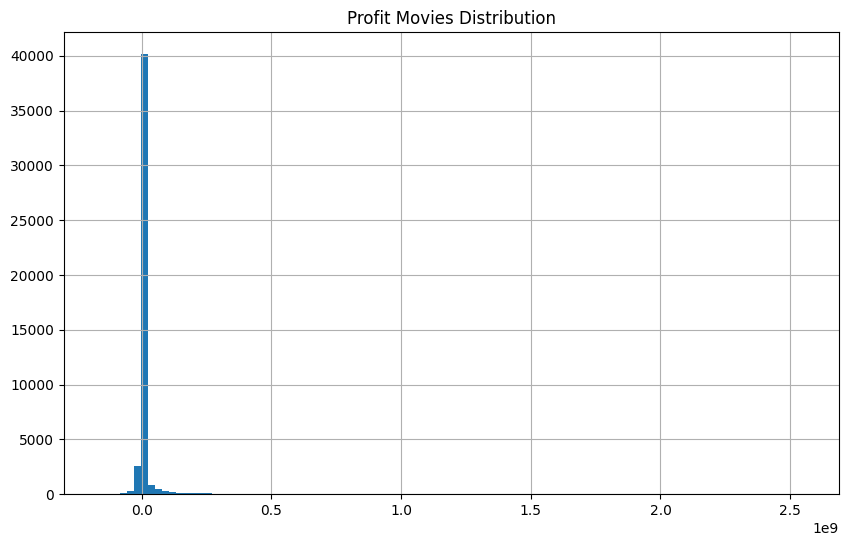

In [42]:
# 10. Visualize Profit Distribution
plt.figure(figsize=(10, 6))
movies_data["profit"].hist(bins=100)
plt.title("Profit Movies Distribution")
plt.show()

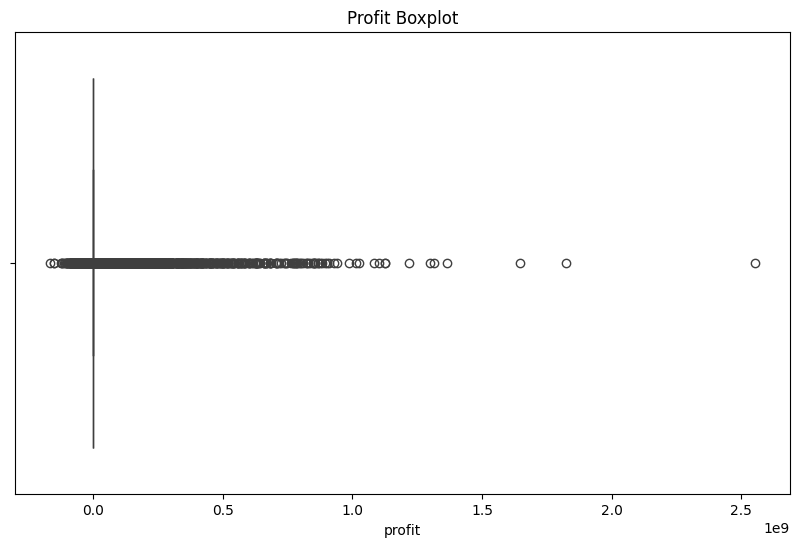

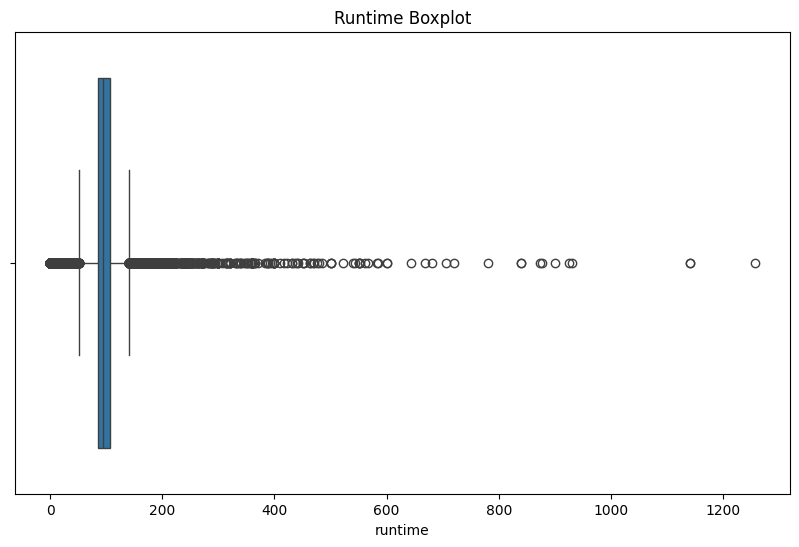

In [43]:
# 11. Boxplot for 'profit' and 'runtime'
plt.figure(figsize=(10, 6))
sns.boxplot(data=movies_data, x="profit")
plt.title("Profit Boxplot")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=movies_data, x="runtime")
plt.title("Runtime Boxplot")
plt.show()

In [ ]:
# 12. Scatterplot for 'runtime' vs 'profit'
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=movies_data, x="runtime", y="profit")
# plt.title("Runtime vs Profit")
# plt.show()

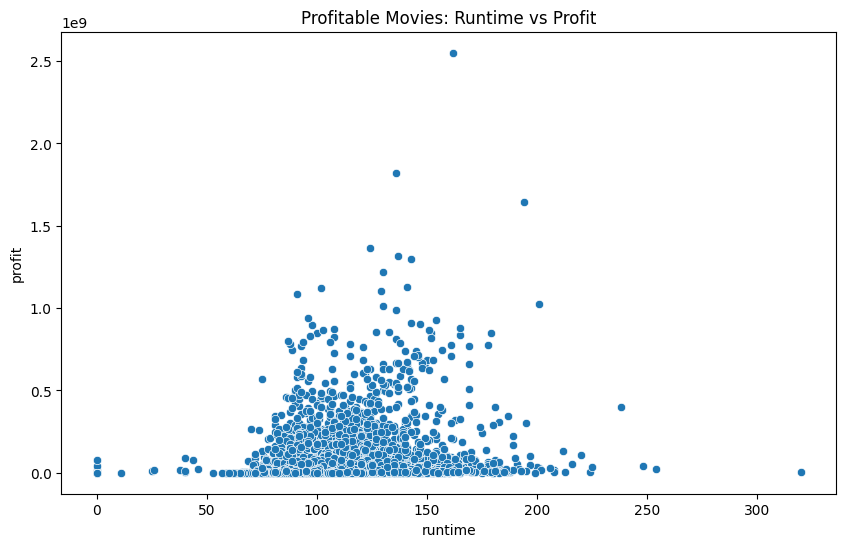

In [60]:
# 13. Filter profitable movies and visualize
profitable_movies = movies_data[movies_data["profit"] > 0]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=profitable_movies, x="runtime", y="profit")
plt.title("Profitable Movies: Runtime vs Profit")
plt.show()

In [45]:
# 14. Rating Median and Categorization
rating_movies = rating.groupby("movieId", as_index=False)["rating"].median()
rating_movies["good_movies"] = rating_movies["rating"] >= 3

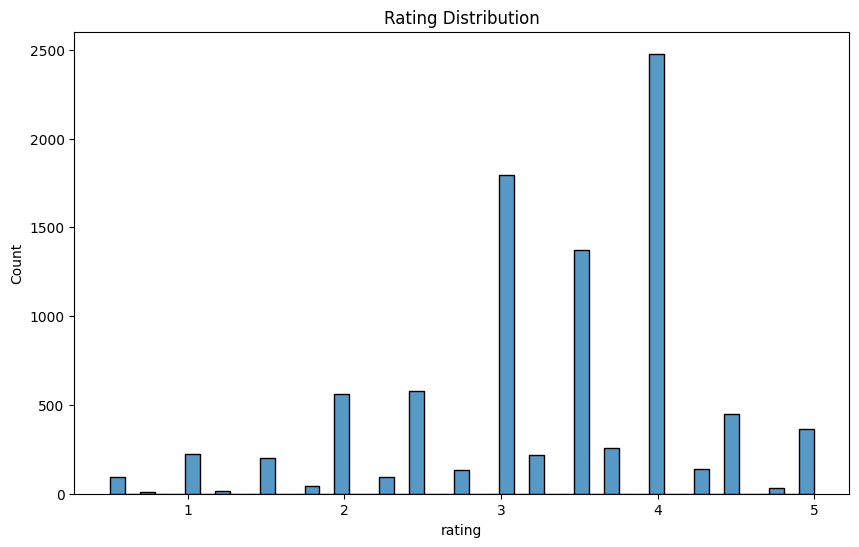

In [46]:
# 15. Visualize Rating Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=rating_movies, x="rating")
plt.title("Rating Distribution")
plt.show()

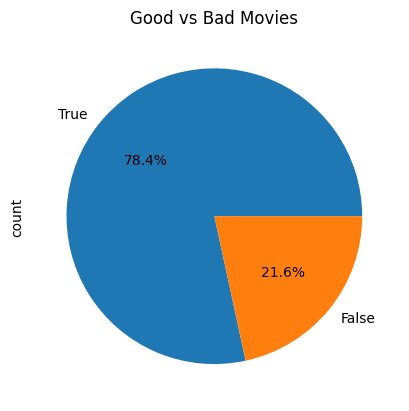

In [47]:
# 16. Pie Chart for Good/Bad Movies
rating_movies["good_movies"].value_counts().plot(kind="pie", autopct='%1.1f%%')
plt.title("Good vs Bad Movies")
plt.show()

In [48]:
# 17. Merge Movie Data and Rating Data
movies_data["id"] = pd.to_numeric(movies_data["id"], errors='coerce')
new_df = movies_data.merge(rating_movies, left_on="id", right_on="movieId", how="inner")

In [ ]:
# 18. Visualize Profit Distribution by Rating
# plt.figure(figsize=(10, 6))
# sns.histplot(data=new_df, x="profit", hue="good_movies", kde=True)
# plt.title("Profit by Rating")
# plt.show()

In [89]:
# 20. Feature Selection for Machine Learning
def select_columns(df: pd.DataFrame, features: list, target: list = "rating"):
    # df = df.dropna().reset_index(drop=True)
    X = df[features]
    y = (df[target] >= 3).astype("float")
    return X, y

In [90]:
# 21. Train-Test Split
features = ["budget", "popularity", "vote_average", "profit_to_budget_ratio", "runtime", "original_language"]
X, y = select_columns(new_df, features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [91]:
# 22. Feature Scaling
minmax = MinMaxScaler()
minmax.fit(X_train)

def scaling(df, scaler):
    scaled_array = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_array, columns=scaler.get_feature_names_out())
    return scaled_df

X_train_scaled = scaling(X_train, minmax)
X_test_scaled = scaling(X_test, minmax)

In [92]:
# 23. Train Models: KNN and Decision Tree
knn = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier()

# Train KNN and Decision Tree
knn.fit(X_train_scaled, y_train)
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [93]:
# 24. Predictions
y_train_pred_knn = knn.predict(X_train_scaled)
y_train_pred_dt = dt.predict(X_train_scaled)
y_test_pred_knn = knn.predict(X_test_scaled)
y_test_pred_dt = dt.predict(X_test_scaled)


In [94]:
# 25. Evaluate Models using Cross-Tabulation
print("KNN Model Evaluation (Test Data):")
print(pd.crosstab(y_test, y_test_pred_knn))

print("Decision Tree Model Evaluation (Test Data):")
print(pd.crosstab(y_test, y_test_pred_dt))


KNN Model Evaluation (Test Data):
col_0   0.0  1.0
rating          
0.0       7  148
1.0      27  668
Decision Tree Model Evaluation (Test Data):
col_0   0.0  1.0
rating          
0.0      34  121
1.0     155  540


In [95]:
from sklearn.metrics import classification_report

# KNN Model Evaluation
print("\nKNN Model Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_knn):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_knn):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_knn):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred_knn):.4f}")

# Display Classification Report for KNN (includes support)
print("\nKNN Classification Report:")
print(classification_report(y_test, y_test_pred_knn))

# Decision Tree Model Evaluation
print("\nDecision Tree Model Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_dt):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_dt):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_dt):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred_dt):.4f}")

# Display Classification Report for Decision Tree (includes support)
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_test_pred_dt))



KNN Model Evaluation Metrics:
Accuracy: 0.7941
Precision: 0.8186
Recall: 0.9612
F1 Score: 0.8842

KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.21      0.05      0.07       155
         1.0       0.82      0.96      0.88       695

    accuracy                           0.79       850
   macro avg       0.51      0.50      0.48       850
weighted avg       0.71      0.79      0.74       850


Decision Tree Model Evaluation Metrics:
Accuracy: 0.6753
Precision: 0.8169
Recall: 0.7770
F1 Score: 0.7965

Decision Tree Classification Report:
              precision    recall  f1-score   support

         0.0       0.18      0.22      0.20       155
         1.0       0.82      0.78      0.80       695

    accuracy                           0.68       850
   macro avg       0.50      0.50      0.50       850
weighted avg       0.70      0.68      0.69       850



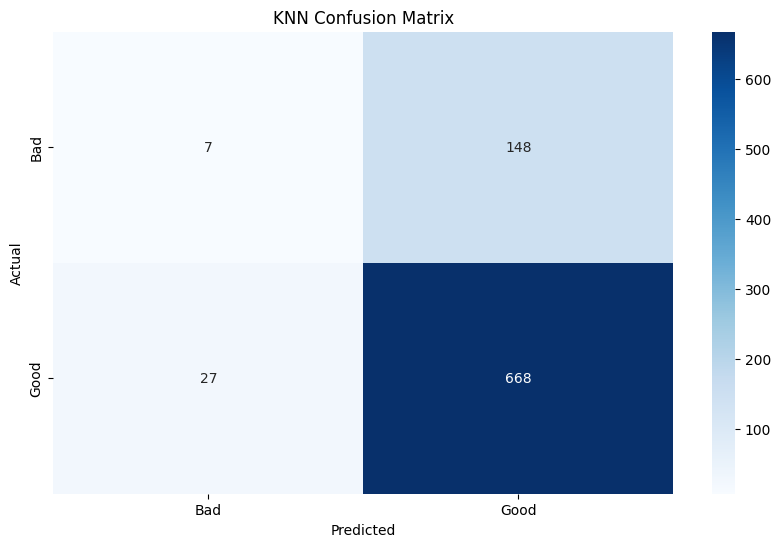

In [96]:
# 27. Confusion Matrix Visualization
plt.figure(figsize=(10, 6))
cm_knn = confusion_matrix(y_test, y_test_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

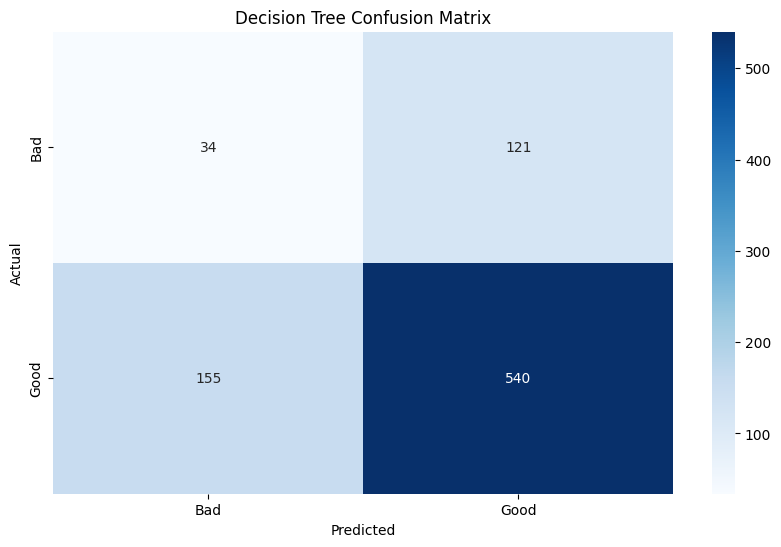

In [97]:
plt.figure(figsize=(10, 6))
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [98]:
new_df.info()
features = ["budget", "popularity", "vote_average", "profit_to_budget_ratio", "runtime", "original_language"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2831 entries, 0 to 2830
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   adult                   2831 non-null   object        
 1   belongs_to_collection   539 non-null    object        
 2   budget                  2831 non-null   float64       
 3   genres                  2831 non-null   object        
 4   homepage                579 non-null    object        
 5   id                      2831 non-null   float64       
 6   imdb_id                 2831 non-null   object        
 7   original_language       2831 non-null   int64         
 8   original_title          2831 non-null   object        
 9   overview                2810 non-null   object        
 10  popularity              2831 non-null   object        
 11  poster_path             2827 non-null   object        
 12  production_companies    2831 non-null   object  

In [99]:
print("Class distribution in the full dataset:")
print(y.value_counts())  # Shows full dataset distribution

print("Class distribution in the training set:")
print(y_train.value_counts())  # Shows training set distribution


Class distribution in the full dataset:
rating
1.0    2328
0.0     503
Name: count, dtype: int64
Class distribution in the training set:
rating
1.0    1633
0.0     348
Name: count, dtype: int64


In [101]:
print(f"Rows dropped due to NaN values: {len(new_df) - new_df.dropna().shape[0]}")


Rows dropped due to NaN values: 2691
